In [1]:
install.packages("recipes")
install.packages("themis")
library(themis)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.5.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed(

HEART DISEASE DIAGNOSES
=======================

Introduction:
-------------
 
   Heart disease is a range of conditions which affect one's cardiovascular system. The most common condition is coronary artery disease, in which plaque builds up in arteries, narrowing the vessel walls. If the buildup continues, blood will have a hard time flowing through these vessels. This condition can lead to heart attacks or strokes. Several factors influence an individual's likelihood to be diagnosed with this condition, including high blood pressure, high cholesterol, and smoking. Poor diet, excessive drinking, poor fitness, and diabetes are also factors. 
	
   Using the patient statistics in the UC Irvine University dataset, can we accurately predict the heart disease diagnoses of other patients? We will be using the aforementioned data set that lists 14 factors which influence the likelihood of heart disease, as well as the diagnoses of this patient. The diagnosis column ranges from 0-4, with 0 being no heart disease detected, and 4 being an extreme presence of the disease. We will be keeping 75% of the data for training and using 25% of it for testing. We will test the accuracy, precision and recall of the predictions that R makes, based off of this dataset. We will use a K nearest neighbor prediction calculation to test if the UC Irvine University dataset can accurately predict a diagnosis.

Research Question: 
------------------
Can we accurately predict if a patient has heart disease based on their age, resting blood pressure, and cholesterol levels? 



Reading The Data:
-----------------

*Training Data*

In [2]:
## cp = chest pain, trestbps = resting blood pressure, fbs = fasting blood sugar > 120 mg/dl, restecg = resting electrocardiographic results
## thalach = maximum heart rate achieved, exang = exercise induced chest pain, oldpeak = ST depression induced by exercise
## slope = he slope of the peak exercise ST segment, Value 1: upsloping, Value 2: flat, Value 3: downsloping
## ca = number of major vessels(0-3), thal = 3 = normal; 6 = fixed defect; 7 = reversable defect, num = diagnosis of heart disease
set.seed(2024)

col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

## Importing the data table
url <- "https://raw.githubusercontent.com/JJyang30/Dsci-100-Data/main/processed.cleveland.data"
heart_data <- read.table(url, 
                         col.names = col_names, sep = ",")

## Selecting the column that we would like to use for this anaylsis
heart_data_analysis <- heart_data |>
    select(age, trestbps, chol, num)|>
    mutate(num = as.factor(num)) 

## Splitting the data into training and testing data using a 75% split
heart_data_split <- initial_split(heart_data_analysis, prop = 0.75, strata = num)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split)

heart_data
heart_data_analysis

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


**Preliminary Exploratory Data Analysis:**

We have summarized the chosen data into two tables. One that contains the averages for the variables of age, chol and trestbps as these values have more variability and another table that contains the variables for sex and the heart disease diagnosis as these two variables have data values that fall into a few distinct levelssure

*Below is the table for the mean of the columns that we selected age, chol, and resting blood pressure*

In [3]:
column_mean <- heart_data_train |> 
    select(age, chol, trestbps)|> 
    map_df(mean)
column_mean

age,chol,trestbps
<dbl>,<dbl>,<dbl>
54.57778,247.9111,131.32


From the table we can see that all three cholesterol, resting blood pressure, and age all have a significantly different average, therefore, their values would also vary and have a wide range. We would need to scale all three predicators in order for our classificatioin model to be accurate.

*Below is the table of the spread of the different scales of diagnosis of heart disease*

In [4]:
num_counts <- heart_data_train |> 
    group_by(num) |> 
    count()
num_counts

num,n
<fct>,<int>
0,122
1,42
2,26
3,26
4,9


From this table we can see that the data points are not spread out equally. The majority of the class has a 0 rating of heart disease. Therefore, in order to perform classification accurately we would need to balance the data first.

**Initial Visualizations**

*Below are the histogram plots that represents each of the three numerical factors against the diagnosis of heart diseases*

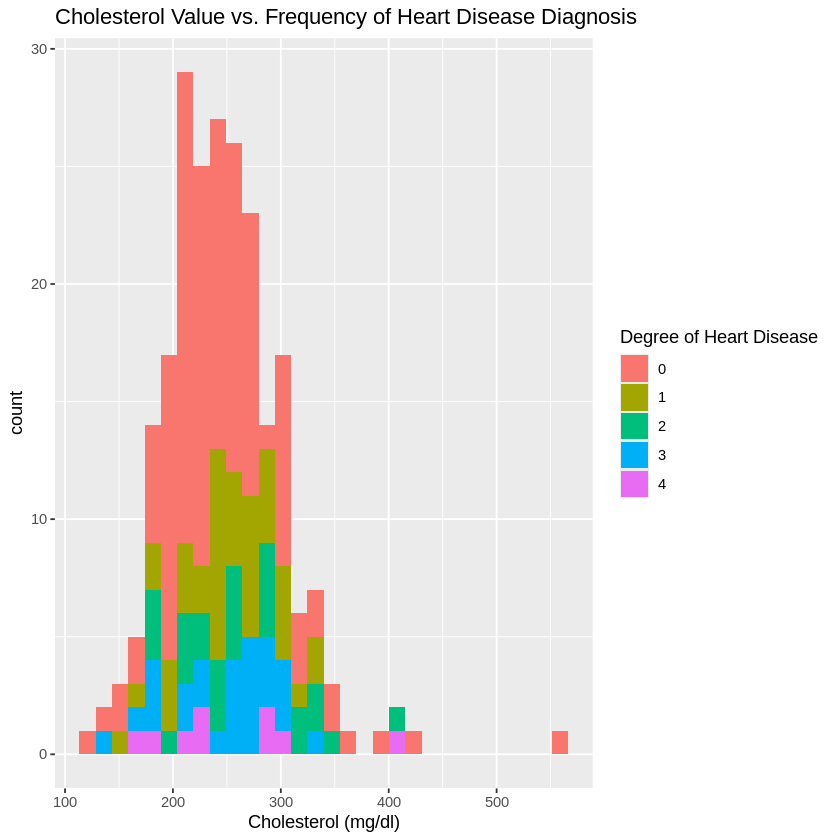

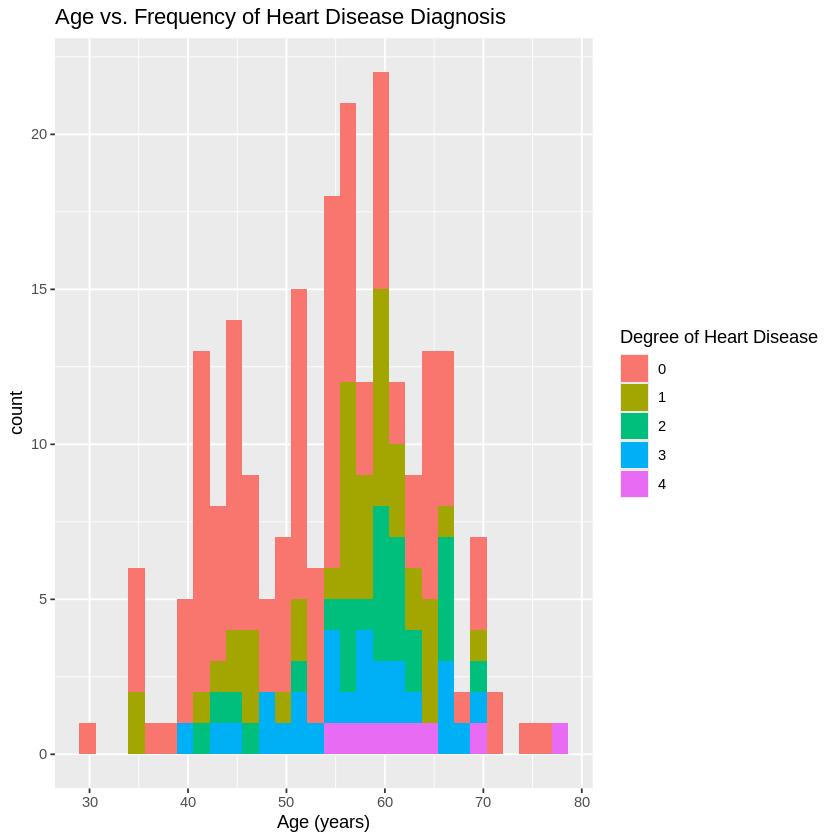

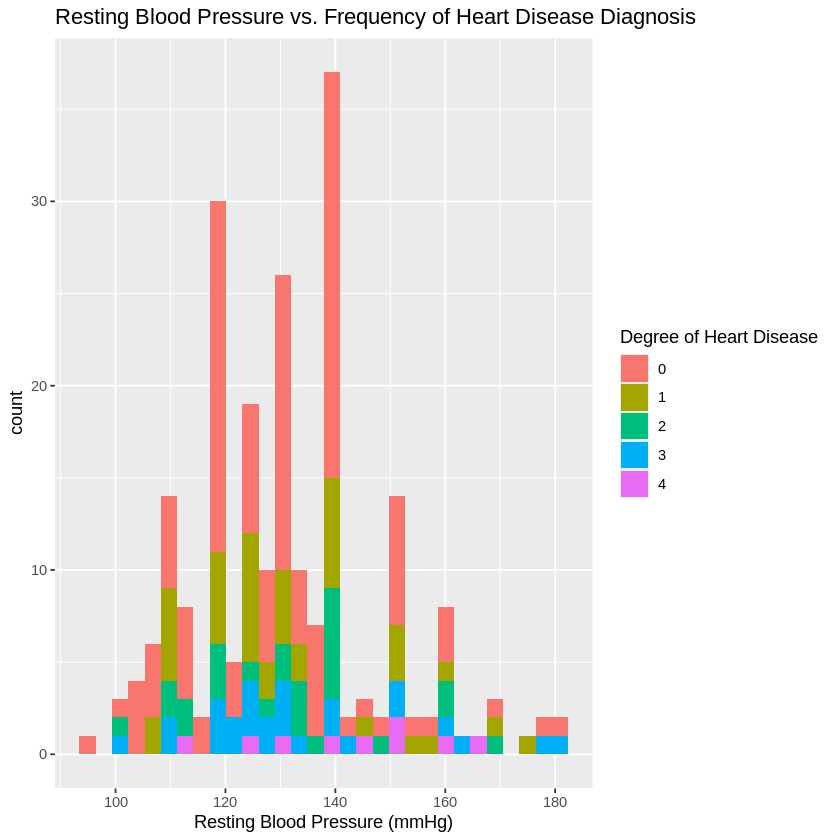

In [5]:
chol_trend_graph <- heart_data_train |> ggplot(aes(x = chol, fill = factor(num))) + 
    geom_histogram(bins = 30) +
    labs(x = "Cholesterol (mg/dl)", 
         title = "Cholesterol Value vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

age_trend_graph <- heart_data_train |> 
    ggplot(aes(x = age, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Age (years)", 
         title = "Age vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

trestbps_trend_graph <- heart_data_train |> 
    ggplot(aes(x = trestbps, fill = factor(num))) + 
    geom_histogram(bins = 30) + 
    labs(x = "Resting Blood Pressure (mmHg)", 
         title = "Resting Blood Pressure vs. Frequency of Heart Disease Diagnosis", 
         fill = "Degree of Heart Disease")

chol_trend_graph
age_trend_graph
trestbps_trend_graph

**Analysis of Initial Visualization**

Cholesterol plot - we can see that the most diagnoses of heart disease from all levels, including diagnoses of no heart disease, fall around the 200 to 300 mg/dl range. Therefore, indicating that heart disease may also be influenced by other factors. 

Age - From the graph we can see that the amount of heart disease diagnoses for levels 1-4 tend to increase as age increases up till around age 60 before it starts declining. We can thus suspect a positive relationship between the variables up to a certain age. 

Resting Blood Pressure - looking at the highest severities, 3 and 4, of heart disease diagnosis, we observe that they are spread relatively equally between the intervals of Resting Blood Pressure, with slightly more diagnoses being made between 120 and 150 mmHg, which is higher than the ideal resting heart rates of people.

## Analysis:

In [6]:
set.seed(2024)

## Setting the number of folds to be 5 for the classification
heart_vfold <- vfold_cv(heart_data_train, v = 5, strata = num)

## Recipe to step up some classes since the classes are unevenly spread(majority are 0)
heart_recipe <- recipe(num ~ age + trestbps + chol, data = heart_data_train)|>
    step_upsample(num, over_ratio = 1, skip = FALSE)|>
    prep()
heart_data_train_unsampled <- bake(heart_recipe, heart_data_train)

## Finalizing our recipe by scaling and centering our predictors
heart_recipe_final <- recipe(num ~ age + trestbps + chol, data = heart_data_train_unsampled)|>
step_scale(all_predictors()) |>
step_center(all_predictors())

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3410127,5,0.03413951,Preprocessor1_Model01
2,accuracy,multiclass,0.3410127,5,0.03413951,Preprocessor1_Model02
3,accuracy,multiclass,0.3913662,5,0.02597023,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,multiclass,0.5252889,5,0.01940891,Preprocessor1_Model23
24,accuracy,multiclass,0.5252889,5,0.01940891,Preprocessor1_Model24
25,accuracy,multiclass,0.5252889,5,0.01940891,Preprocessor1_Model25


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,accuracy,multiclass,0.5469438,5,0.02514672,Preprocessor1_Model12


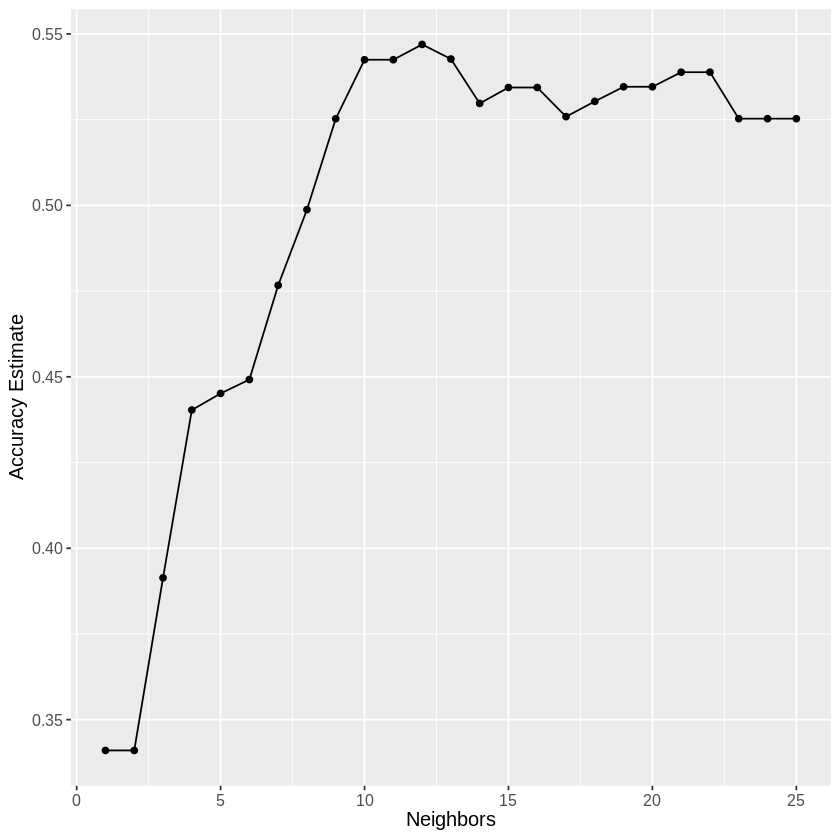

In [7]:
## Setting up our tune, to find the most accurate K neighbour in the classification mode
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
## Creating a tibble to test K values from 1 - 25 going up by 1 each time
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

## Adding our recipe and fold to find the most accurate K value
heart_workflow <- workflow() |> add_recipe(heart_recipe_final) |> add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

## Filtering the metrics to display accuracy as we are doing a classification
knn_accuracies <- heart_workflow |> 
    filter(.metric == "accuracy")

## Slicing to show the most accurate K value
best_k <- knn_accuracies |> 
    arrange(desc(mean)) |>
    head(1)

## Plotting out the K values
knn_accuracies_plot <- ggplot(knn_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

knn_accuracies
best_k
knn_accuracies_plot

In [8]:
set.seed(2024)

## Setting the specs with the most accurate K Value that we found
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
    set_engine("kknn") |>
    set_mode("classification")

## Fitting our training data
heart_best_fit <- workflow() |>
    add_recipe(heart_recipe_final) |>
    add_model(knn_best_spec) |>
    fit(data = heart_data_train)

## Making predictions on our testing data
heart_test_predictions <- predict(heart_best_fit , heart_data_test) |>
    bind_cols(heart_data_test)

## The accuracy of the prediction on the testing data
heart_prediction_accuracy <- heart_test_predictions |>
    metrics(truth = num, estimate = .pred_class) 

## The precision of the prediction on the testing data
heart_prediction_precision <- heart_test_predictions |>
    precision(truth = num, estimate = .pred_class)

## The recall of the prediction on the testing data
heart_prediction_recall <- heart_test_predictions |>
    recall(truth = num, estimate = .pred_class)

heart_prediction_accuracy
heart_prediction_precision
heart_prediction_recall

Warning message:
“While computing multiclass `precision()`, some levels had no predicted events (i.e. `true_positive + false_positive = 0`). 
Precision is undefined in this case, and those levels will be removed from the averaged result.
Note that the following number of true events actually occured for each problematic event level:
'3': 9
'4': 4”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5000000
kap,multiclass,0.0881295


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.4388889


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.2434432


Methods:
--------
After running our cross validation we can see that we have a 50% chance of predicting the right diagnosis. This accuracy can be justified since there are a total of 5 classes, 0-4, and random guessing would only give a 20% chance of getting the right class. Therefore, a 50% accuracy through our classification algorithm is understandable despite it not being ideal. A factor that could have affected the accuracy was due to the complexity of the data, since there were 13 possible predictors and we only selected three to predict the class. By contrast, Shouman et al.’s use of the KNN classifier with all 13 predictor variables produces significantly more accurate predictions with 97.4% accuracy for k=7 (2012). The level of complexity in the data makes it difficult to make an accurate prediction without over-complicating the algorithm by including all the variables as predictors. If we had done so, our algorithm may have been overloaded with too many dimensions to consider. This was a limitation that Shouman and co-authors also highlighted in the process of their research. Additionally, Subramani et al. found that other forms of more complex machine learning, and which involve stacking models, produce more accurate predictions compared to the KNN model (2023). They argue that traditional machine learning models such as the KNN model are restricted in their predictive abilities, which corroborates with what we have found given a limited number of predictor variables. Hence, contrary to our expectations, we find that our model cannot accurately predict the heart disease diagnosis of patients to an extent that will be beneficial to hospitals. 

In addition to accuracy, the recall may not be as high as required for clinical reliability given that the model was only limited to 3 predictors out of possible 13, this limitation could have hindered the model’s ability to detect all true positive cases of heart disease and could lead to a high number of false negatives where patients with heart disease are wrongfully identified as healthy. 

A potential implication of our findings is that heart disease is a complex diagnosis and the multitude of factors involved mean that it should either employ a model with a larger number of predictors or diagnosis should be considered on a case-by-case basis for accuracy and treatment. The questions that we would like to pose for future consideration is thus whether it is possible for algorithms capable of handling more complex functions to accurately predict heart disease diagnoses and if other predictors will give a more accurate diagnosis for heart diseases. By addressing these questions, future research can contribute to the development of more accurate and efficient predictive models for heart disease. 


Discussion:
----------
A classification model’s accuracy measures the total correct classifications against the total classifications made. After running our cross validation we can see that we have a 50% chance of predicting the right diagnosis. This accuracy can be justified since there are a total of 5 classes, 0-4, and random guessing would only give a 20% chance of getting the right class. Therefore, a 50% accuracy through our classification algorithm is understandable despite it not being ideal. A factor that could have affected the accuracy was due to the complexity of the data, since there were 13 possible predictors and we only selected three to predict the class. In contrast, Shouman et al.’s use of the KNN classifier with all 13 predictor variables produces significantly more accurate predictions with 97.4% accuracy for k=7 (2012). However, to consider all 13 variables, they used the KNN classification model for the discrete variables in the dataset as well. Their variables consisted of discrete ones instead of solely continuous ones. This, as mentioned in their research paper and in the textbook (Timbers, et al., 2023), is not often done and npt ideal. The level of complexity in the data thus makes it difficult to make an accurate prediction without over-complicating the algorithm by including all the variables as predictors. If we had done so, our algorithm may have been overloaded with too many dimensions to consider. This was a limitation that Shouman and co-authors also highlighted in the process of their research. Additionally, Subramani et al. found that other forms of more complex machine learning, which involve stacking models, produce more accurate predictions compared to the KNN model (2023). They argue that traditional machine learning models such as the KNN model are restricted in their predictive abilities, which corroborates with what we have found when we used a limited number of predictor variables. 

In addition to accuracy, a classifier's precision measures the proportion of true positive predictions against all positive predictions made by the classifying model. Our model was found to have a 25% precision. This means that only a quarter of the positive predictions made by our model are actually correct. This is a relatively low precision for a classification model. Likewise, the recall we attained for our model may not be as high as required for clinical reliability. A reason for these findings is that the model was only limited to 3 predictors out of the possible 13 as mentioned previously. This limitation could have hindered the model’s ability to detect all true positive cases of heart disease. It could lead to a high number of false positives (where healthy patients are incorrectly diagnosed to have a heart disease) and false negatives (where patients with heart disease are incorrectly identified as healthy). A model with high precision and recall would thus be difficult to achieve unless all predictors are used in the classifier.

Hence, contrary to our expectations, we find that our model unfortunately cannot accurately, precisely or reliably predict the heart disease diagnosis of patients to an extent that will be beneficial to hospitals. It would be detrimental to use it without further improvements to the model due to its high prediction rate for false positives and false negatives. A false-positive diagnosis of heart disease costs a patient tremendous amounts of unnecessary stress and money if they have to pay medical charges for further testing and treatment. False negatives are also extremely dangerous for a patient since their condition would not be treated and they would not make any lifestyle changes to manage this condition. This could potentially lead to an unexpected death from heart disease, or a later diagnosis of the disease that comes with increased risks. For example, more extensive, expensive and dangerous surgeries and treatments. 

A potential implication of our findings is that heart disease is a complex diagnosis and the multitude of factors involved mean that it should either employ a model with a larger number of predictors or diagnosis should be considered on a case-by-case basis for accuracy and treatment. The questions that we would like to pose for future consideration is thus whether it is possible for algorithms capable of handling more complex functions to accurately predict heart disease diagnoses and if other predictors will give a more accurate diagnosis for heart diseases. By addressing these questions, future research can contribute to the development of more accurate and efficient predictive models for heart disease. 




References and Credits:
-----------------------

- Janosi, A., et al. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.
- Shouman, M., et al. (2012). Applying K-nearest neighbour in diagnosing heart disease ... Applying k-Nearest Neighbour in Diagnosing Heart Disease Patients. http://www.ijiet.org/papers/114-K0009.pdf 
- Subramani, S., et al. (2023). Cardiovascular diseases prediction by machine learning incorporation with Deep Learning. Frontiers. https://www.frontiersin.org/articles/10.3389/fmed.2023.1150933/full#:~:
text=The%20algorithm%20model%20uses%20machine,%2C%20ECG%20signal%2C%20and%20cholesterol.
- Timbers, T., et al. (2023). Data science. http://datasciencebook.ca/classification1.html#data-preprocessing-with-tidymodels 

